# Four-qubit Schwinger model

In [1]:
import numpy as np
from qiskit import IBMQ, Aer, QuantumCircuit, pulse, transpile
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

from cross_resonance import LinearizedCR, PulseEfficientCR, DefaultRtt, cx_circuit
from model_circuits import single_step_no_opt, single_step, two_steps

In [2]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibm_lagos')

simulator = Aer.get_backend('qasm_simulator')

In [3]:
def combine_counts(counts_list):
    counts = {}
    for circ_counts in counts_list:
        for key, value in circ_counts.items():
            try:
                counts[key] += value
            except KeyError:
                counts[key] = value
                
    return counts

In [4]:
nsites = 4

J = 1. # Hamiltonian J parameter
mu = 0.5 # Hamiltonian mu parameter

M = 10 # number of Trotter steps
omegadt = 0.2 # Trotter step size

In [5]:
initial = QuantumCircuit(nsites, nsites)
initial.x(1)
initial.x(3)

## Reference: Naive circuit on simulator

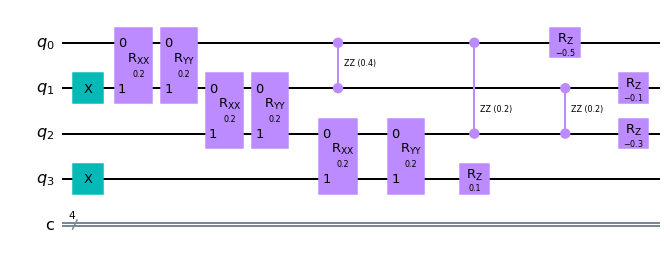

In [6]:
reference = initial.compose(single_step_no_opt(J, mu, omegadt))
reference.draw('mpl')

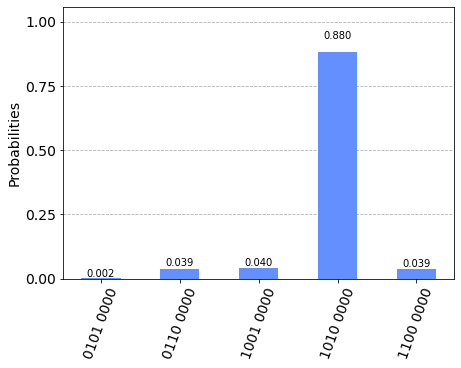

In [7]:
plot_histogram(simulator.run(reference.measure_all(inplace=False), shots=10000).result().get_counts())

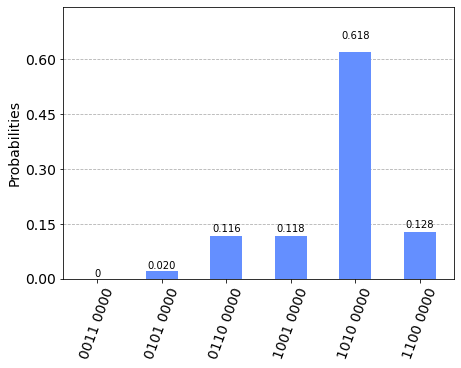

In [8]:
reference.compose(single_step_no_opt(J, mu, omegadt), inplace=True)
plot_histogram(simulator.run(reference.measure_all(inplace=False), shots=10000).result().get_counts())

## Reference: Optimized circuits with DefaultRtt on simulator

In [9]:
rtt = DefaultRtt()
crs_default = dict((key, rtt) for key in [(0, 1), (1, 2), (2, 3)])

onestep_cnot = single_step(J, mu, omegadt, crs=crs_default)
twostep_cnot = two_steps(J, mu, omegadt, crs=crs_default)

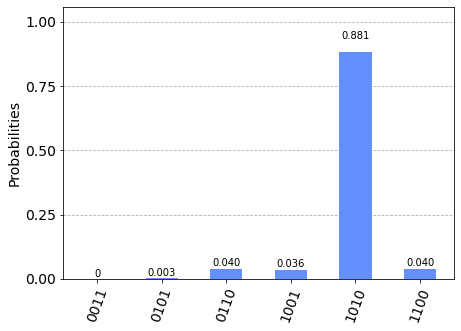

In [10]:
circuit = initial.compose(onestep_cnot)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=simulator)
plot_histogram(simulator.run(circuit, shots=10000).result().get_counts())

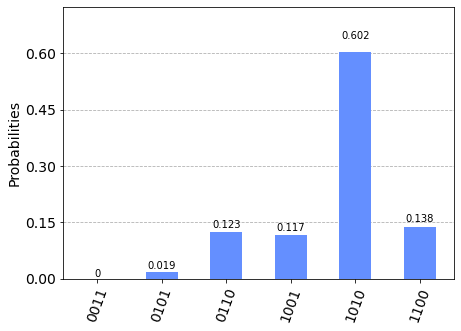

In [11]:
circuit = initial.compose(twostep_cnot)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=simulator)
plot_histogram(simulator.run(circuit, shots=10000).result().get_counts())

## Reference: Optimized circuits with DefaultRtt and decomposed CNOT on simulator

In [12]:
cxs_rzx = {
    (0, 1): cx_circuit(backend, 1, 3, use_rzx=True),
    (1, 0): cx_circuit(backend, 3, 1, use_rzx=True)
}

onestep_cnot_cxres = single_step(J, mu, omegadt, crs=crs_default, cxs=cxs_rzx)
twostep_cnot_cxres = two_steps(J, mu, omegadt, crs=crs_default, cxs=cxs_rzx)

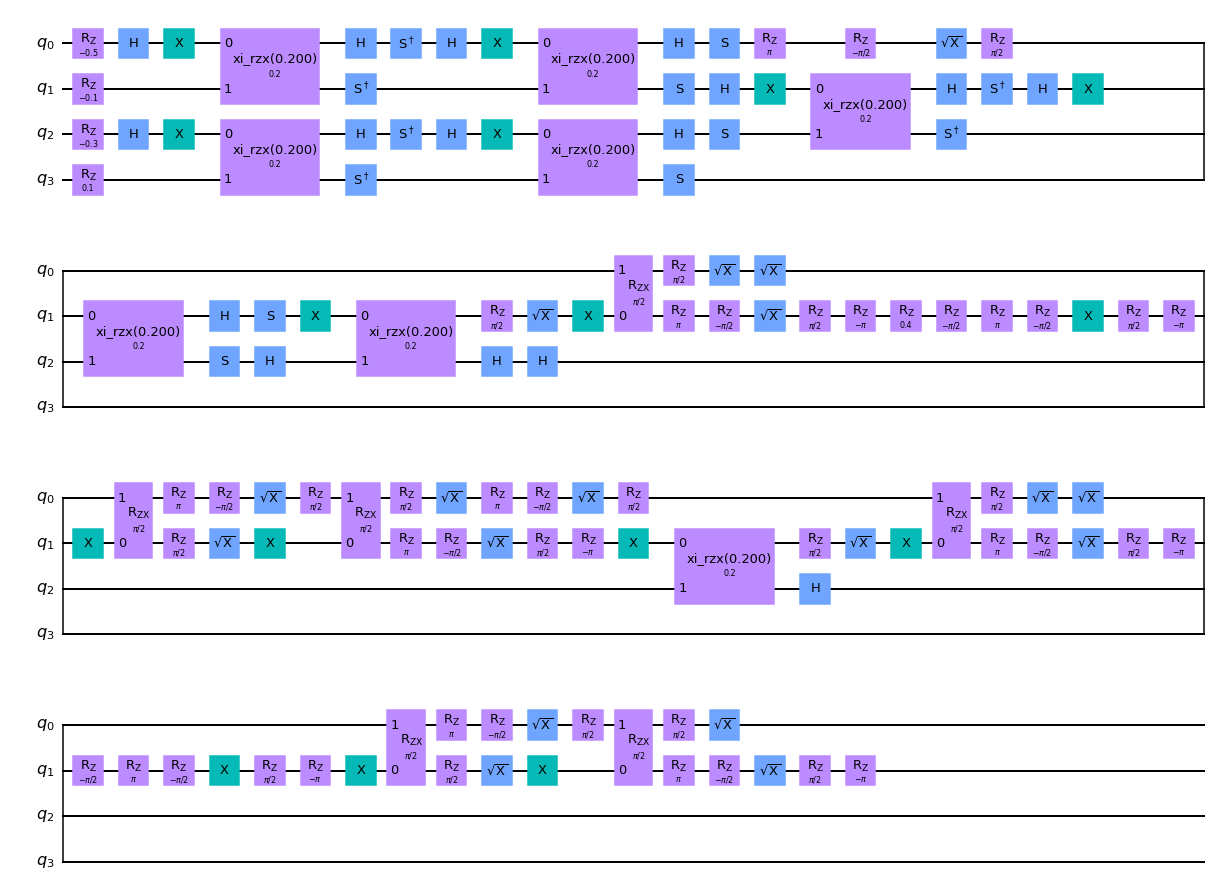

In [13]:
onestep_cnot_cxres.draw('mpl')

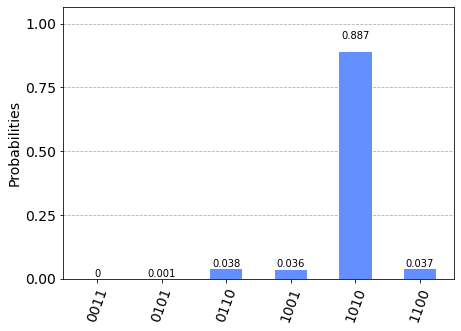

In [14]:
circuit = initial.compose(onestep_cnot_cxres)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=simulator)
plot_histogram(simulator.run(circuit, shots=10000).result().get_counts())

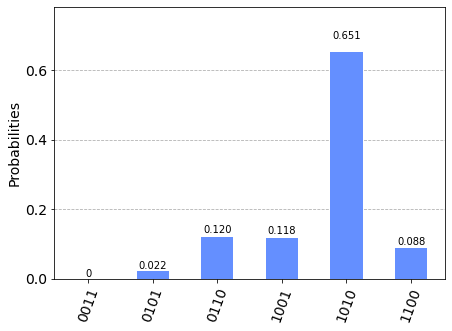

In [15]:
circuit = initial.compose(twostep_cnot_cxres)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=simulator)
plot_histogram(simulator.run(circuit, shots=10000).result().get_counts())

## Optimized 1-step circuit with DefaultRtt on ibmq_jakarta

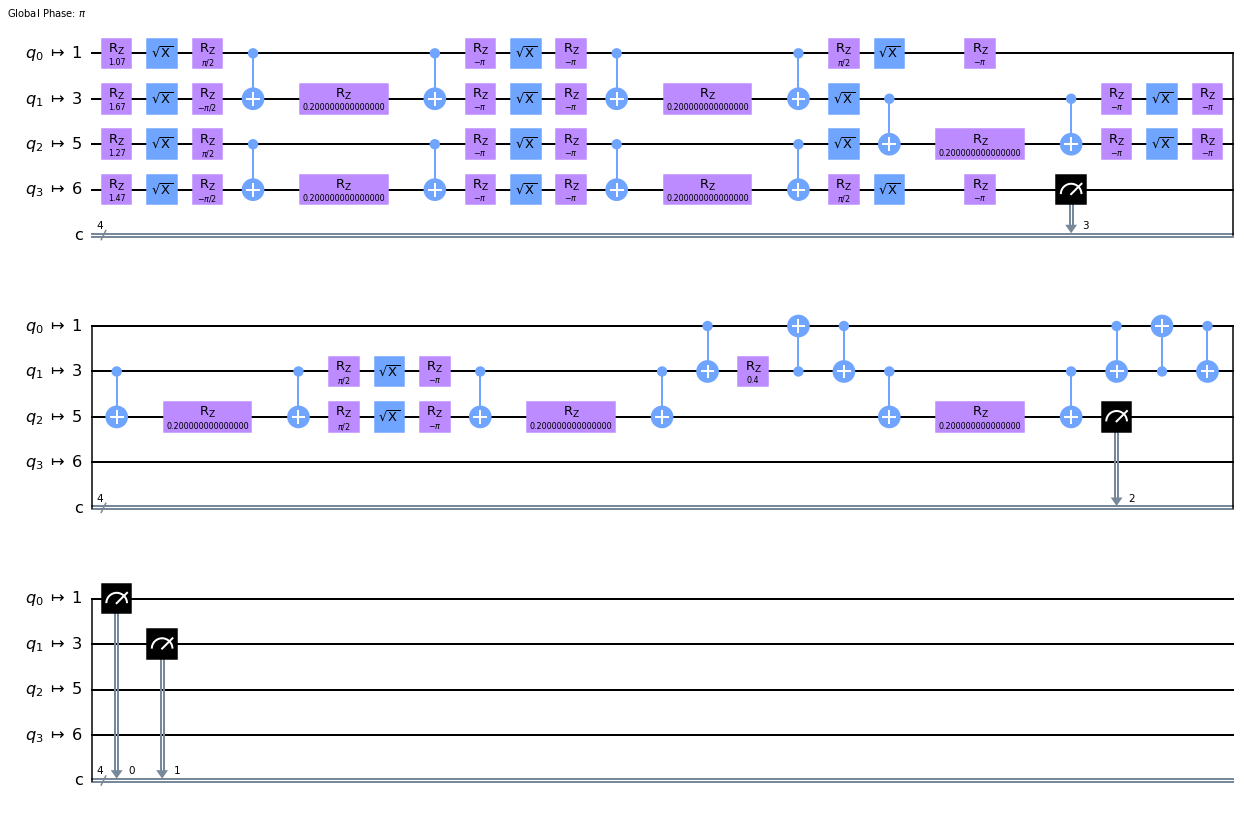

In [16]:
circuit = initial.compose(onestep_cnot)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=backend, initial_layout=[1, 3, 5, 6])

circuit.draw('mpl', idle_wires=False)

In [17]:
#job = backend.run([circuit] * 10, shots=8192)
#print(job.job_id())
#job_monitor(job)
#job = backend.retrieve_job('6163d8bdc978669c59093cc3')

In [18]:
#plot_histogram(combine_counts(job.result().get_counts()))

## Optimized 1-step circuit with DefaultRtt and decomposed CNOT on ibmq_jakarta

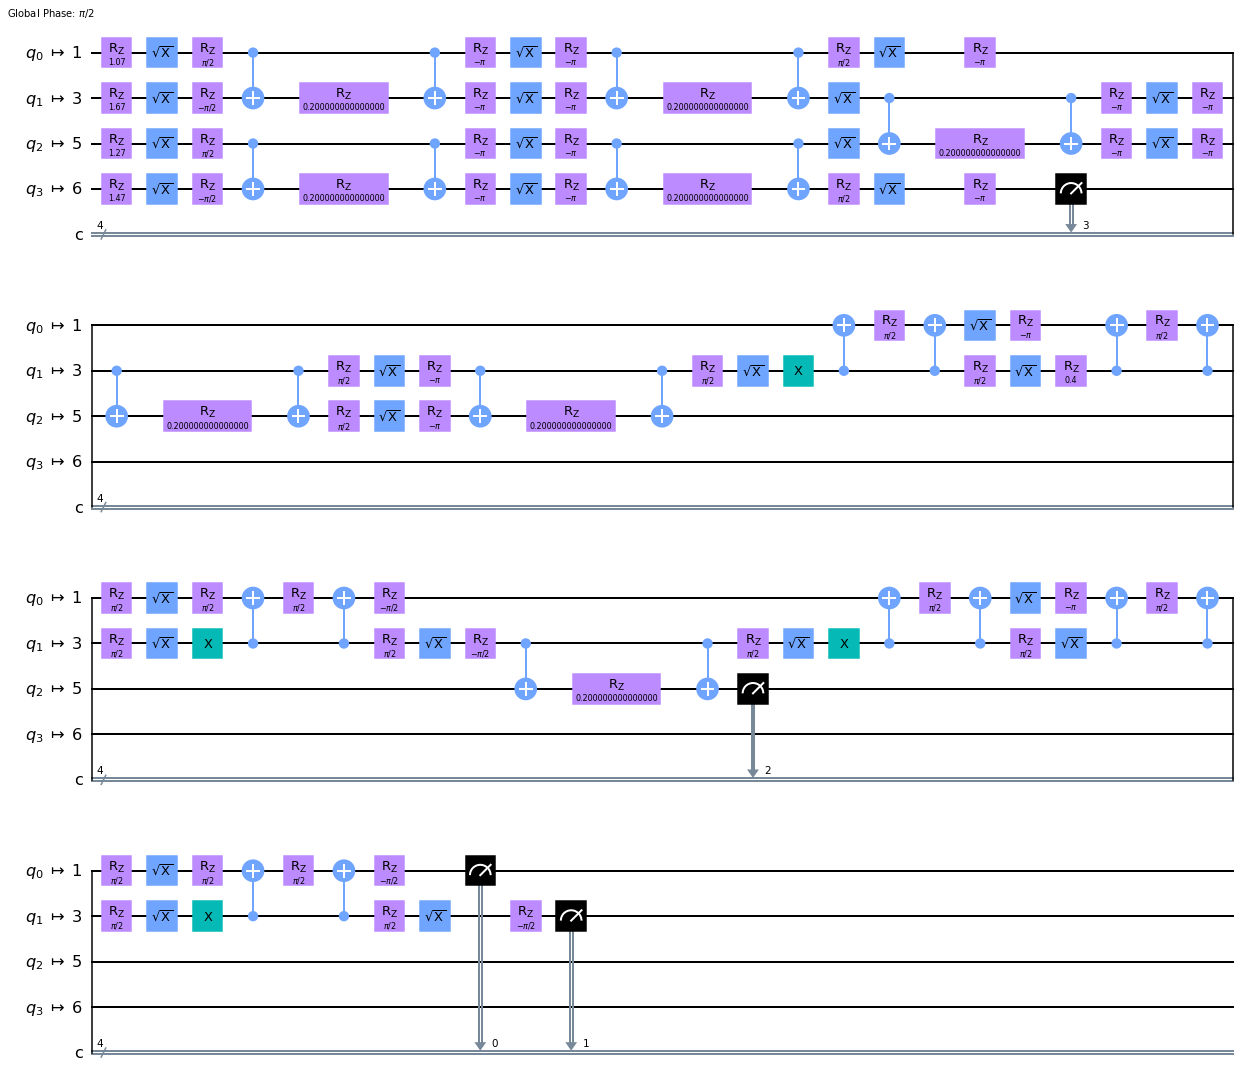

In [19]:
circuit = initial.compose(onestep_cnot_cxres)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=backend, initial_layout=[1, 3, 5, 6])

circuit.draw('mpl', idle_wires=False)

In [20]:
#job = backend.run([circuit] * 10, shots=8192)
#print(job.job_id())
#job_monitor(job)
#job = backend.retrieve_job('6163e5280fa7c31687a282d5')

In [21]:
#plot_histogram(combine_counts(job.result().get_counts()))

## Optimized 1-step circuit with PulseEfficientCR on ibmq_jakarta

In [22]:
crs_pe = {
    (0, 1): PulseEfficientCR(backend, (1, 3)),
    (1, 2): PulseEfficientCR(backend, (3, 5)),
    (2, 3): PulseEfficientCR(backend, (5, 6))
}

onestep_pe = single_step(J, mu, omegadt, crs=crs_pe)
twostep_pe = two_steps(J, mu, omegadt, crs=crs_pe)

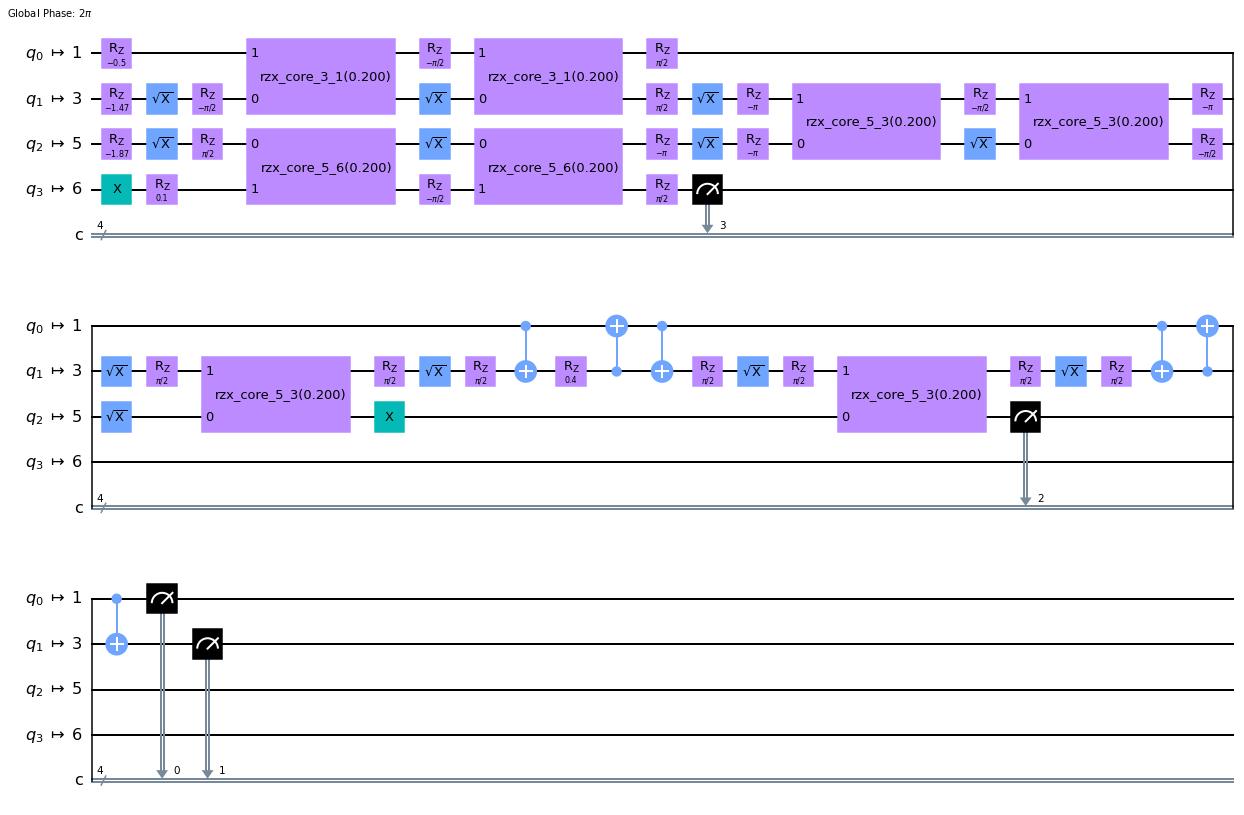

In [23]:
circuit = initial.compose(onestep_pe)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=backend, initial_layout=[1, 3, 5, 6])

circuit.draw('mpl', idle_wires=False)

In [24]:
job = backend.run([circuit] * 10, shots=8192)
print(job.job_id())
job_monitor(job)
#job = backend.retrieve_job('616452429f1b4a761bffb65a')

6164d8c2cce80b1ab80875f5
Job Status: job has successfully run


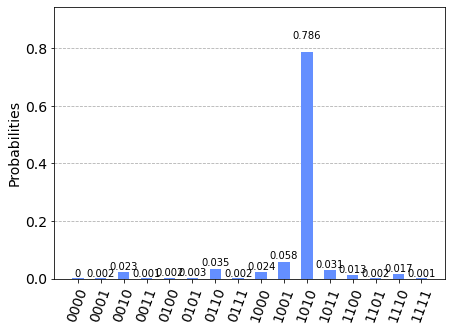

In [25]:
plot_histogram(combine_counts(job.result().get_counts()))

## Optimized 1-step circuit with LinearizedCR on ibmq_jakarta

In [26]:
crs_li = {
    (0, 1): LinearizedCR(backend, (1, 3)),
    (1, 2): LinearizedCR(backend, (3, 5)),
    (2, 3): LinearizedCR(backend, (5, 6))
}
crs_li[(0, 1)].load_calibration('58a018c8-1029-4bbf-9ad1-a16e57220444')
crs_li[(1, 2)].load_calibration('d95780a6-120a-4df6-a63f-1049ee3b53bc')
crs_li[(2, 3)].load_calibration('b8648948-fb0a-408a-bdf8-c2a2a99684b7')

onestep_li = single_step(J, mu, omegadt, crs=crs_li)
twostep_li = two_steps(J, mu, omegadt, crs=crs_li)

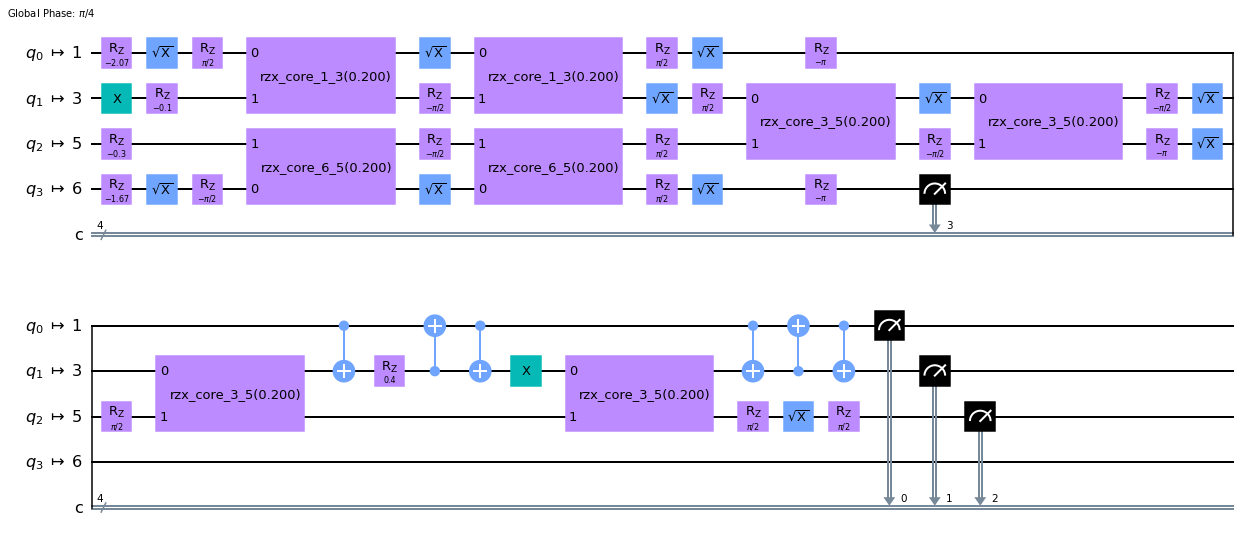

In [27]:
circuit = initial.compose(onestep_li)
circuit.measure(circuit.qregs[0], circuit.cregs[0])
circuit = transpile(circuit, backend=backend, initial_layout=[1, 3, 5, 6])

circuit.draw('mpl', idle_wires=False)

In [28]:
#job = backend.run([circuit] * 10, shots=8192)
#print(job.job_id())
#job_monitor(job)
job = backend.retrieve_job('6164570ffc7bdf64b143f206')

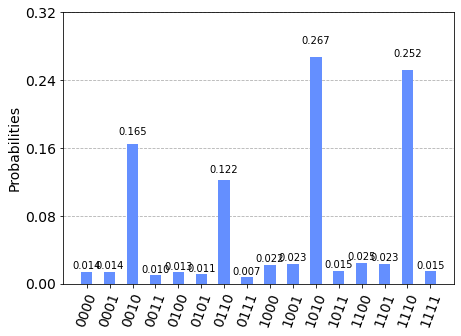

In [29]:
plot_histogram(combine_counts(job.result().get_counts()))